In [40]:
# Import library
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("Healthcare").getOrCreate()

# Load dataset
df = spark.read.load("/content/healthcare_dataset.csv",format="csv", sep=",", inferSchema="true", header="true")
df.show(10)

+------------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|              Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|          Doctor|            Hospital|Insurance Provider|    Billing Amount|Room Number|Admission Type|Discharge Date| Medication|Test Results|
+------------------+---+------+----------+-----------------+-----------------+----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|     Bobby JacksOn| 30|  Male|        B-|           Cancer|       2024-01-31|   Matthew Smith|     Sons and Miller|        Blue Cross|18856.281305978155|        328|        Urgent|    2024-02-02|Paracetamol|      Normal|
|      LesLie TErRy| 62|  Male|        A+|          Obesity|       2019-08-20| Samantha Davies|             Kim 

In [3]:
# Check dataframe schema
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance Provider: string (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Room Number: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)



In [4]:
# Check missing values
df_null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
df_null

{'Name': 0,
 'Age': 0,
 'Gender': 0,
 'Blood Type': 0,
 'Medical Condition': 0,
 'Date of Admission': 0,
 'Doctor': 0,
 'Hospital': 0,
 'Insurance Provider': 0,
 'Billing Amount': 0,
 'Room Number': 0,
 'Admission Type': 0,
 'Discharge Date': 0,
 'Medication': 0,
 'Test Results': 0}

In [5]:
# Create database table
df.createOrReplaceTempView("Healthcare")

+----------+------------+------------+
|Blood Type|Test Results|Avg. Billing|
+----------+------------+------------+
|        O-|      Normal|    26427.92|
|       AB-|    Abnormal|    26028.84|
|        O+|Inconclusive|    25921.75|
|        O-|Inconclusive|    25865.68|
|        B-|    Abnormal|    25791.01|
|        B+|Inconclusive|     25790.6|
|        A+|Inconclusive|    25787.61|
|        A-|    Abnormal|     25748.1|
|        A+|    Abnormal|    25741.59|
|        A-|Inconclusive|    25707.17|
|       AB+|    Abnormal|    25699.24|
|        B-|Inconclusive|    25636.27|
|       AB-|      Normal|    25627.11|
|        B+|      Normal|    25597.01|
|       AB+|      Normal|    25521.28|
|        A+|      Normal|    25461.17|
|       AB-|Inconclusive|     25419.9|
|        A-|      Normal|    25331.52|
|        O+|    Abnormal|    25294.61|
|        B-|      Normal|    25146.58|
+----------+------------+------------+
only showing top 20 rows



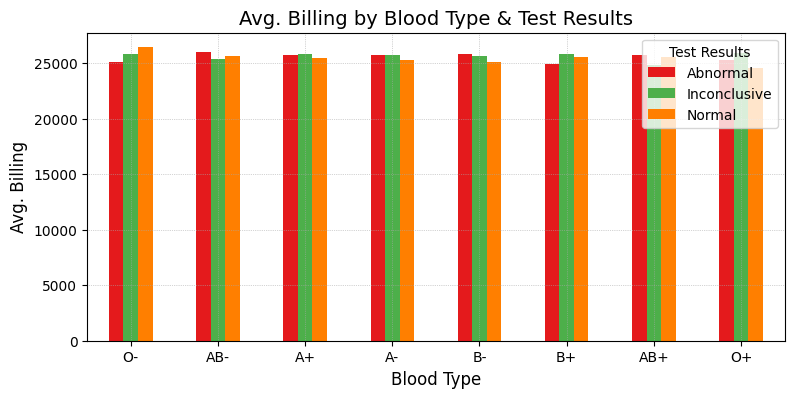

In [15]:
# How many avg. billing by blood type and test result
billing_blood_test = spark.sql("""
  SELECT
    `Blood Type`,
    `Test Results`,
    ROUND(AVG(`Billing Amount`),2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY `Blood Type`, `Test Results`
  ORDER BY `Avg. Billing` DESC;
""")
# Display the result
billing_blood_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_blood_test_pd = billing_blood_test.toPandas()

# Pivot the DataFrame to reorganize data by blood type and test results
billing_blood_test_pivot = billing_blood_test_pd.pivot_table(
    index='Blood Type',
    columns='Test Results',
    values='Avg. Billing',
    aggfunc='mean'
)

# Add a column for avg. billing and sort by it in descending order
billing_blood_test_pivot['Avg. Billing'] = billing_blood_test_pivot.sum(axis=1)
billing_blood_test_pivot = billing_blood_test_pivot.sort_values('Avg. Billing', ascending=False)

# Plot the data
color_palette = plt.cm.Set1([i / len(billing_blood_test_pivot.columns)
                             for i in range(len(billing_blood_test_pivot.columns))])

billing_blood_test_pivot.drop('Avg. Billing', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(9, 4)
)

# Add plot details
plt.title('Avg. Billing by Blood Type & Test Results', fontsize=14)
plt.ylabel('Avg. Billing', fontsize=12)
plt.xlabel('Blood Type', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Test Results')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+------+------------+------------+
|Gender|Test Results|Avg. Billing|
+------+------------+------------+
|  Male|Inconclusive|    25807.46|
|  Male|    Abnormal|    25580.89|
|Female|    Abnormal|    25496.04|
|Female|      Normal|    25474.18|
|Female|Inconclusive|    25441.42|
|  Male|      Normal|    25439.44|
+------+------------+------------+



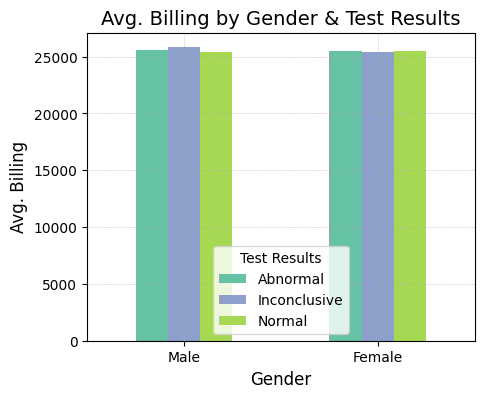

In [13]:
# How many avg. billing by gender and test result
billing_gender_test = spark.sql("""
  SELECT
    Gender,
    `Test Results`,
    ROUND(AVG(`Billing Amount`),2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY Gender, `Test Results`
  ORDER BY `Avg. Billing` DESC;
""")
# Display the result
billing_gender_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_gender_test_pd = billing_gender_test.toPandas()

# Pivot the DataFrame to reorganize data by gender and test results
billing_gender_test_pivot = billing_gender_test_pd.pivot_table(
    index='Gender',
    columns='Test Results',
    values='Avg. Billing',
    aggfunc='mean'
)

# Add a column for avg. billing and sort by it in descending order
billing_gender_test_pivot['Avg. Billing'] = billing_gender_test_pivot.sum(axis=1)
billing_gender_test_pivot = billing_gender_test_pivot.sort_values('Avg. Billing', ascending=False)

# Plot the data
color_palette = plt.cm.Set2([i / len(billing_gender_test_pivot.columns)
                             for i in range(len(billing_gender_test_pivot.columns))])

billing_gender_test_pivot.drop('Avg. Billing', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(5, 4)
)

# Add plot details
plt.title('Avg. Billing by Gender & Test Results', fontsize=14)
plt.ylabel('Avg. Billing', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Test Results')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+-----------------+------------+------------+
|Medical Condition|Test Results|Avg. Billing|
+-----------------+------------+------------+
|     Hypertension|Inconclusive|    25862.93|
|           Asthma|Inconclusive|    25840.54|
|          Obesity|      Normal|    25834.25|
|         Diabetes|Inconclusive|    25823.15|
|          Obesity|    Abnormal|    25817.79|
|          Obesity|Inconclusive|    25765.38|
|         Diabetes|    Abnormal|    25687.35|
|        Arthritis|      Normal|    25643.17|
|           Asthma|      Normal|    25599.33|
|     Hypertension|    Abnormal|    25595.77|
|        Arthritis|    Abnormal|    25545.58|
|           Asthma|    Abnormal|    25466.16|
|         Diabetes|      Normal|     25406.1|
|        Arthritis|Inconclusive|    25304.32|
|           Cancer|      Normal|     25223.2|
|           Cancer|Inconclusive|    25150.24|
|           Cancer|    Abnormal|    25113.09|
|     Hypertension|      Normal|    25042.61|
+-----------------+------------+--

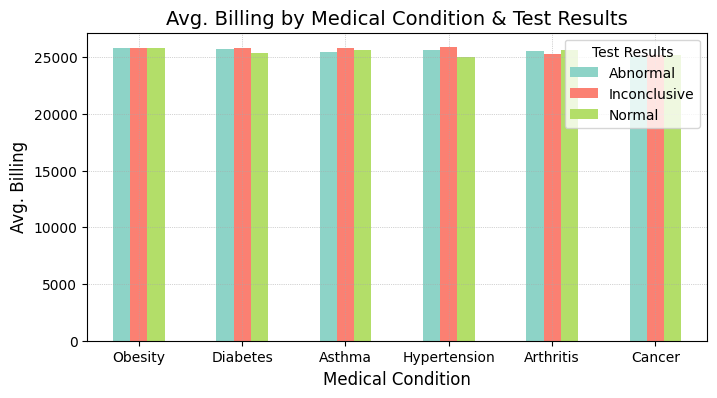

In [17]:
# How many avg. billing by medical condition and test result
billing_medical_test = spark.sql("""
  SELECT
    `Medical Condition`,
    `Test Results`,
    ROUND(AVG(`Billing Amount`),2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY `Medical Condition`, `Test Results`
  ORDER BY `Avg. Billing` DESC;
""")
# Display the result
billing_medical_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_medical_test_pd = billing_medical_test.toPandas()

# Pivot the DataFrame to reorganize data by medical condition and test results
billing_medical_test_pivot = billing_medical_test_pd.pivot_table(
    index='Medical Condition',
    columns='Test Results',
    values='Avg. Billing',
    aggfunc='mean'
)

# Add a column for avg. billing and sort by it in descending order
billing_medical_test_pivot['Avg. Billing'] = billing_medical_test_pivot.sum(axis=1)
billing_medical_test_pivot = billing_medical_test_pivot.sort_values('Avg. Billing', ascending=False)

# Plot the data
color_palette = plt.cm.Set3([i / len(billing_medical_test_pivot.columns)
                             for i in range(len(billing_medical_test_pivot.columns))])

billing_medical_test_pivot.drop('Avg. Billing', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(8, 4)
)

# Add plot details
plt.title('Avg. Billing by Medical Condition & Test Results', fontsize=14)
plt.ylabel('Avg. Billing', fontsize=12)
plt.xlabel('Medical Condition', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Test Results')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+------------------+------------+------------+
|Insurance Provider|Test Results|Avg. Billing|
+------------------+------------+------------+
|        Blue Cross|Inconclusive|     25784.6|
|        Blue Cross|    Abnormal|    25777.58|
|          Medicare|    Abnormal|    25726.75|
|             Cigna|Inconclusive|    25709.66|
|             Aetna|Inconclusive|    25707.26|
|          Medicare|      Normal|    25559.75|
|          Medicare|Inconclusive|    25558.49|
|             Aetna|      Normal|    25522.49|
|             Cigna|      Normal|    25470.89|
| United Healthcare|      Normal|    25453.29|
|             Aetna|    Abnormal|    25428.83|
|             Cigna|    Abnormal|    25399.84|
| United Healthcare|    Abnormal|    25363.62|
| United Healthcare|Inconclusive|    25348.81|
|        Blue Cross|      Normal|    25277.13|
+------------------+------------+------------+



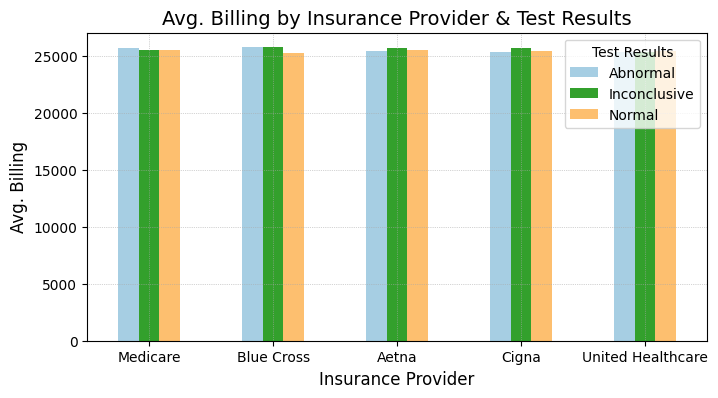

In [19]:
# How many avg. billing by insurance provider and test result
billing_insurance_test = spark.sql("""
  SELECT
    CASE
      WHEN `Insurance Provider` = 'UnitedHealthcare'
      THEN 'United Healthcare'
      ELSE `Insurance Provider`
    END AS `Insurance Provider`,
    `Test Results`,
    ROUND(AVG(`Billing Amount`),2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY `Insurance Provider`, `Test Results`
  ORDER BY `Avg. Billing` DESC;
""")
# Display the result
billing_insurance_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_insurance_test_pd = billing_insurance_test.toPandas()

# Pivot the DataFrame to reorganize data by insurance provider and test results
billing_insurance_test_pivot = billing_insurance_test_pd.pivot_table(
    index='Insurance Provider',
    columns='Test Results',
    values='Avg. Billing',
    aggfunc='mean'
)

# Add a column for avg. billing and sort by it in descending order
billing_insurance_test_pivot['Avg. Billing'] = billing_insurance_test_pivot.sum(axis=1)
billing_insurance_test_pivot = billing_insurance_test_pivot.sort_values('Avg. Billing', ascending=False)

# Plot the data
color_palette = plt.cm.Paired([i / len(billing_insurance_test_pivot.columns)
                             for i in range(len(billing_insurance_test_pivot.columns))])

billing_insurance_test_pivot.drop('Avg. Billing', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(8, 4)
)

# Add plot details
plt.title('Avg. Billing by Insurance Provider & Test Results', fontsize=14)
plt.ylabel('Avg. Billing', fontsize=12)
plt.xlabel('Insurance Provider', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Test Results')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+--------------+------------+------------+
|Admission Type|Test Results|Avg. Billing|
+--------------+------------+------------+
|        Urgent|Inconclusive|    25896.12|
|      Elective|      Normal|    25672.35|
|      Elective|Inconclusive|    25585.09|
|     Emergency|    Abnormal|    25581.37|
|      Elective|    Abnormal|    25549.36|
|     Emergency|      Normal|    25524.48|
|        Urgent|    Abnormal|    25485.26|
|     Emergency|Inconclusive|    25385.93|
|        Urgent|      Normal|    25171.33|
+--------------+------------+------------+



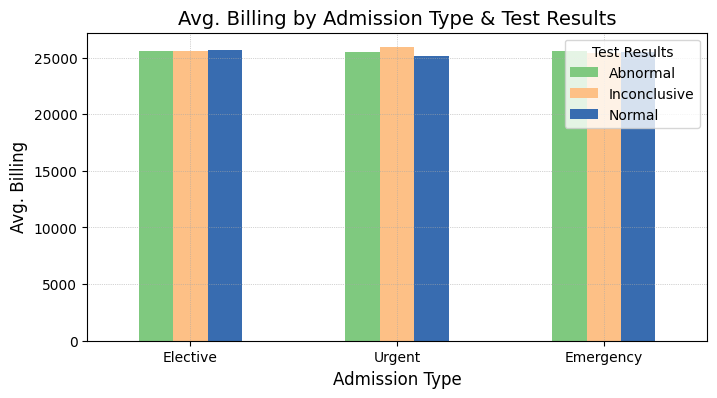

In [20]:
# How many avg. billing by admission type and test result
billing_admission_test = spark.sql("""
  SELECT
    `Admission Type`,
    `Test Results`,
    ROUND(AVG(`Billing Amount`),2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY `Admission Type`, `Test Results`
  ORDER BY `Avg. Billing` DESC;
""")
# Display the result
billing_admission_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_admission_test_pd = billing_admission_test.toPandas()

# Pivot the DataFrame to reorganize data by admission type and test results
billing_admission_test_pivot = billing_admission_test_pd.pivot_table(
    index='Admission Type',
    columns='Test Results',
    values='Avg. Billing',
    aggfunc='mean'
)

# Add a column for avg. billing and sort by it in descending order
billing_admission_test_pivot['Avg. Billing'] = billing_admission_test_pivot.sum(axis=1)
billing_admission_test_pivot = billing_admission_test_pivot.sort_values('Avg. Billing', ascending=False)

# Plot the data
color_palette = plt.cm.Accent([i / len(billing_admission_test_pivot.columns)
                             for i in range(len(billing_admission_test_pivot.columns))])

billing_admission_test_pivot.drop('Avg. Billing', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(8, 4)
)

# Add plot details
plt.title('Avg. Billing by Admission Type & Test Results', fontsize=14)
plt.ylabel('Avg. Billing', fontsize=12)
plt.xlabel('Admission Type', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Test Results')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+-----------+------------+------------+
| Medication|Test Results|Avg. Billing|
+-----------+------------+------------+
|  Ibuprofen|Inconclusive|     26244.0|
|Paracetamol|      Normal|    25904.99|
| Penicillin|    Abnormal|     25828.0|
| Penicillin|Inconclusive|    25766.67|
|    Aspirin|      Normal|     25754.5|
|    Aspirin|    Abnormal|    25657.76|
|  Ibuprofen|    Abnormal|    25506.07|
|    Lipitor|Inconclusive|    25481.29|
|  Ibuprofen|      Normal|    25469.65|
|Paracetamol|    Abnormal|    25431.53|
|    Aspirin|Inconclusive|    25363.57|
|    Lipitor|      Normal|    25275.25|
|    Lipitor|    Abnormal|    25269.05|
|Paracetamol|Inconclusive|    25268.27|
| Penicillin|      Normal|    24881.36|
+-----------+------------+------------+



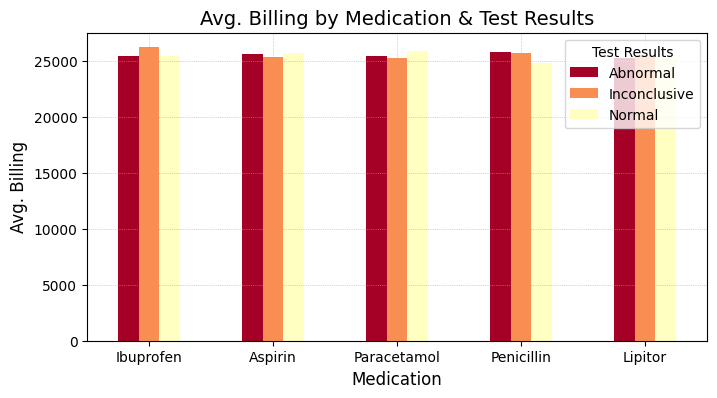

In [23]:
# How many avg. billing by medication and test result
billing_medication_test = spark.sql("""
  SELECT
    Medication,
    `Test Results`,
    ROUND(AVG(`Billing Amount`),2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY Medication, `Test Results`
  ORDER BY `Avg. Billing` DESC;
""")
# Display the result
billing_medication_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_medication_test_pd = billing_medication_test.toPandas()

# Pivot the DataFrame to reorganize data by medication and test results
billing_medication_test_pivot = billing_medication_test_pd.pivot_table(
    index='Medication',
    columns='Test Results',
    values='Avg. Billing',
    aggfunc='mean'
)

# Add a column for avg. billing and sort by it in descending order
billing_medication_test_pivot['Avg. Billing'] = billing_medication_test_pivot.sum(axis=1)
billing_medication_test_pivot = billing_medication_test_pivot.sort_values('Avg. Billing', ascending=False)

# Plot the data
color_palette = plt.cm.RdYlBu([i / len(billing_medication_test_pivot.columns)
                             for i in range(len(billing_medication_test_pivot.columns))])

billing_medication_test_pivot.drop('Avg. Billing', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(8, 4)
)

# Add plot details
plt.title('Avg. Billing by Medication & Test Results', fontsize=14)
plt.ylabel('Avg. Billing', fontsize=12)
plt.xlabel('Medication', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.legend(title='Test Results')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+------------+------------+
|Test Results|Avg. Billing|
+------------+------------+
|Inconclusive|    25623.69|
|    Abnormal|    25538.35|
|      Normal|    25456.65|
+------------+------------+



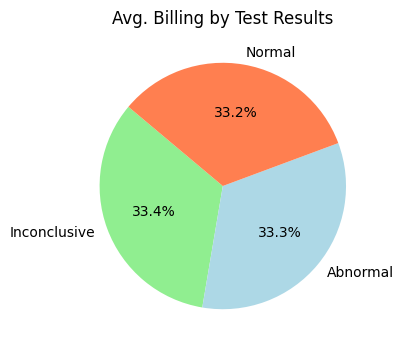

In [24]:
# How many avg. billing by test result
billing_test = spark.sql("""
  SELECT
    `Test Results`,
    ROUND(AVG(`Billing Amount`),2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY `Test Results`
  ORDER BY `Avg. Billing` DESC;
""")
# Display the result
billing_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_test_pd = billing_test.toPandas()

# Plotting the pie chart
plt.figure(figsize=(5, 4))
plt.pie(
    billing_test_pd['Avg. Billing'],
    labels=billing_test_pd['Test Results'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightblue', 'coral'],  # Add more colors if necessary
    startangle=140
)
plt.title('Avg. Billing by Test Results')
plt.show()

+--------------+------------+------------+
|Discharge Year|Test Results|Avg. Billing|
+--------------+------------+------------+
|          2019|    Abnormal|    25982.14|
|          2019|      Normal|    25900.65|
|          2019|Inconclusive|    25389.02|
|          2020|      Normal|    25527.27|
|          2020|    Abnormal|    24999.46|
|          2020|Inconclusive|    25472.13|
|          2021|Inconclusive|    25833.06|
|          2021|    Abnormal|    25789.48|
|          2021|      Normal|    25449.27|
|          2022|Inconclusive|    25713.45|
|          2022|    Abnormal|    25667.41|
|          2022|      Normal|    25202.89|
|          2023|Inconclusive|    25736.98|
|          2023|    Abnormal|    25580.31|
|          2023|      Normal|    25312.44|
|          2024|    Abnormal|    25149.97|
|          2024|      Normal|    25599.08|
|          2024|Inconclusive|    25350.01|
+--------------+------------+------------+



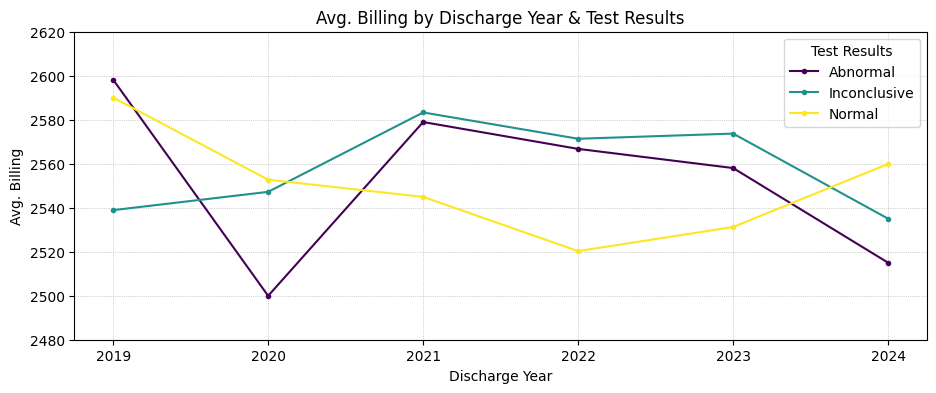

In [28]:
# How many avg. billing by discharge year & test results
billing_discharge_year_test = spark.sql("""
  SELECT
    YEAR(`Discharge Date`) AS `Discharge Year`,
    `Test Results`,
    ROUND(AVG(`Billing Amount`),2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY YEAR(`Discharge Date`), `Test Results`
  ORDER BY YEAR(`Discharge Date`);
""")
# Display the result
billing_discharge_year_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_discharge_year_test_pd = billing_discharge_year_test.toPandas()
# Visualize Total Sales by Order Year & Product Category
billing_discharge_year_test_pd.groupby(['Discharge Year', 'Test Results'])['Avg. Billing'].mean().unstack().plot(marker = '.', cmap = 'viridis',
                                                                                                        figsize = (11,4))
plt.title('Avg. Billing by Discharge Year & Test Results', loc = 'center')
plt.xlabel('Discharge Year')
plt.ylabel('Avg. Billing')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 0.5)
labels, locations = plt.yticks()
plt.yticks(labels, (labels/10).astype(int))
plt.show()

+---------------+------------+------------+------------+
|Discharge Month|Test Results|Month Number|Avg. Billing|
+---------------+------------+------------+------------+
|            Jan|    Abnormal|           1|    25115.49|
|            Jan|Inconclusive|           1|    25763.96|
|            Jan|      Normal|           1|     25076.0|
|            Feb|Inconclusive|           2|    25570.59|
|            Feb|    Abnormal|           2|     25316.6|
|            Feb|      Normal|           2|     25927.5|
|            Mar|      Normal|           3|    25552.94|
|            Mar|    Abnormal|           3|    25657.74|
|            Mar|Inconclusive|           3|    25529.21|
|            Apr|      Normal|           4|    25160.07|
|            Apr|    Abnormal|           4|    25133.87|
|            Apr|Inconclusive|           4|    25089.68|
|            May|      Normal|           5|    25544.73|
|            May|    Abnormal|           5|    25436.11|
|            May|Inconclusive| 

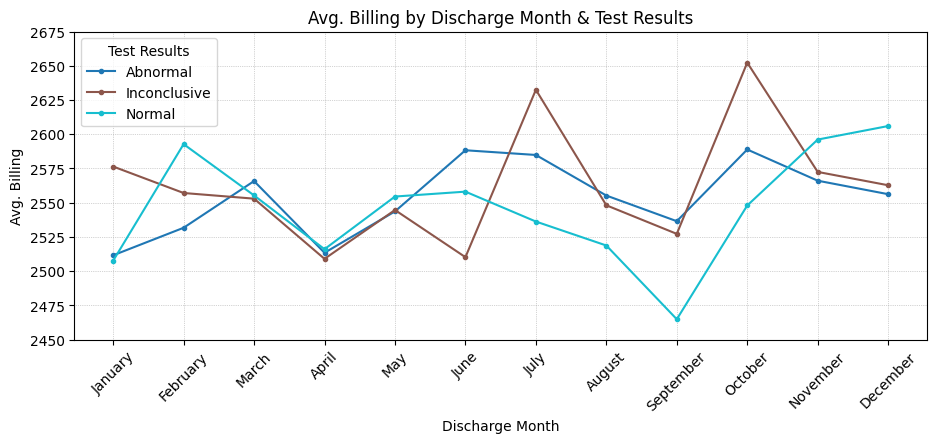

In [50]:
# How many avg. billing by discharge month & test results
billing_discharge_month_test = spark.sql("""
  SELECT
    DATE_FORMAT(`Discharge Date`, 'MMM') AS `Discharge Month`,
    `Test Results`,
    MONTH(`Discharge Date`) AS `Month Number`,
    ROUND(AVG(`Billing Amount`), 2) AS `Avg. Billing`
  FROM Healthcare
  GROUP BY DATE_FORMAT(`Discharge Date`, 'MMM'), `Test Results`, MONTH(`Discharge Date`)
  ORDER BY MONTH(`Discharge Date`);
""")
# Display the result
billing_discharge_month_test.show()

# Convert Spark DataFrame to Pandas DataFrame
billing_discharge_month_test_pd = billing_discharge_month_test.toPandas()

# Ensure correct order by sorting by 'Month Number'
billing_discharge_month_test_pd['Discharge Month'] = pd.to_datetime(billing_discharge_month_test_pd['Discharge Month'], format='%b').dt.month_name()

# Group and plot data
billing_discharge_month_test_pd.groupby(['Month Number', 'Discharge Month', 'Test Results'])['Avg. Billing'].mean().unstack().plot(
    marker='.', cmap='tab10', figsize=(11, 4))

# Set chart title and labels
plt.title('Avg. Billing by Discharge Month & Test Results', loc='center')
plt.xlabel('Discharge Month')
plt.ylabel('Avg. Billing')

# Format the y-axis for better readability
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
labels, locations = plt.yticks()
plt.yticks(labels, (labels/10).astype(int))

# Ensure months are ordered correctly
plt.xticks(ticks=range(12), labels=[*billing_discharge_month_test_pd['Discharge Month'].unique()], rotation=45)

# Show the plot
plt.show()